In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
dimension = 2**9
print(dimension)
rho0_l = 0.2
rho0_s = 0.01
# rho0 = 0.2
# dx = 0.25
dx = 1/dimension

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

H = np.eye(dimension)[::2]
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [6]:
eig_val_l, eig_vec_l, P_l, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_l, covariance.fft_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('long variance: ', eig_val_l.mean())
eig_val_l = eig_val_l / eig_val_l.mean()
sort_index = np.argsort(sort_index)
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]
P_l = eig_vec_l @ np.diag(eig_val_l) @ eig_vec_l.conj().T
P_l = P_l.real

eig_val_s, eig_vec_s, P_s, sort_index = covariance.generate_circulant(
    dimension, dx, rho0_s, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_sort_ind=True)
print('short variance: ', eig_val_s.mean())
eig_val_s = eig_val_s / eig_val_s.mean()
sort_index = np.argsort(sort_index)
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]
P_s = eig_vec_s @ np.diag(eig_val_s) @ eig_vec_s.conj().T
P_s = P_s.real
#P_s = P_s/P_s.max()

al = 0.5
eig_val = (1 - al) * eig_val_s + al * eig_val_l
eig_vec = eig_vec_l.copy()

eig_val = eig_val / eig_val.mean()

sort_index = np.argsort(eig_val)[::-1]
eig_val = eig_val[sort_index]
eig_vec = eig_vec[:, sort_index]

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

sort_index = np.argsort(eig_val_l)[::-1]
eig_val_l = eig_val_l[sort_index]
eig_vec_l = eig_vec_l[:, sort_index]

sort_index = np.argsort(eig_val_s)[::-1]
eig_val_s = eig_val_s[sort_index]
eig_vec_s = eig_vec_s[:, sort_index]


R = np.eye(obs_size)

trans_mats_true = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)


trans_mats_long = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_l, eig_vec_p=eig_vec_l,
    R=R, return_Ts=True)


trans_mats_short = assimilate.transformation_matrices(
    H, eig_val_p=eig_val_s, eig_vec_p=eig_vec_s,
    R=R, return_Ts=True)


for key, val in trans_mats_true.items():
    exec(key + '=val')
for key, val in trans_mats_long.items():
    exec(key+'_l' + '=val')
for key, val in trans_mats_short.items():
    exec(key+'_s' + '=val')

long variance:  1.0115883817859526
short variance:  0.9999999999999999


Log10(condition):  5.041597203443353


Text(0.5, 0.98, 'Eigenvalues P_s')

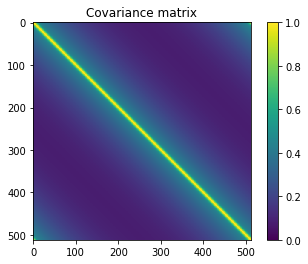

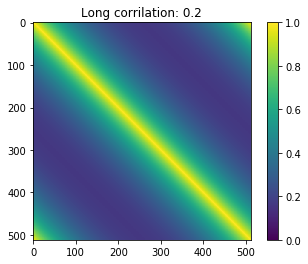

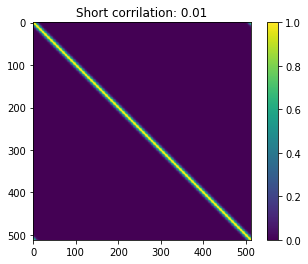

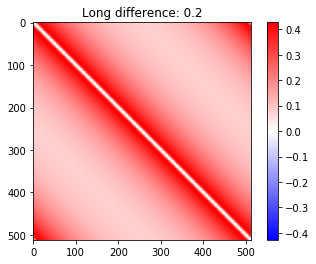

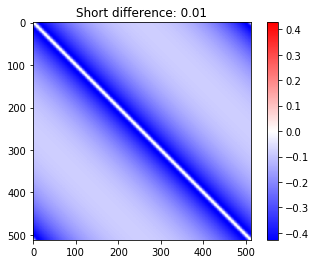

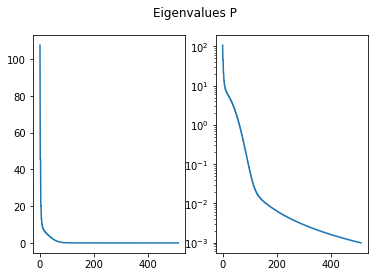

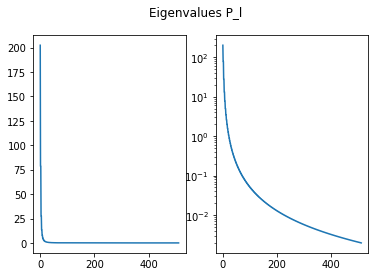

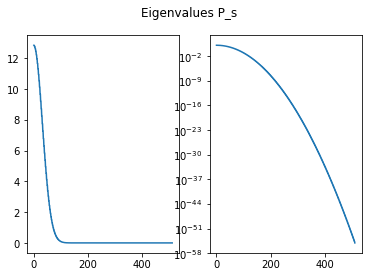

In [7]:
imshow(P, title='Covariance matrix', vmin=0, vmax=1)
imshow(P_l, title=f'Long corrilation: {rho0_l}', vmin=0, vmax=1)
imshow(P_s, title=f'Short corrilation: {rho0_s}', vmin=0, vmax=1)

error_l = P_l - P
error_s = P_s - P

vmax = np.max([np.abs(error_l).max(),
               np.abs(error_s).max()])

imshow(error_l, title=f'Long difference: {rho0_l}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
imshow(error_s, title=f'Short difference: {rho0_s}',
       vmin=-vmax, vmax=vmax, cmap='bwr')
print('Log10(condition): ',
      np.log10(np.linalg.cond(P)))

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val)
ax[1].semilogy(eig_val)
plt.suptitle('Eigenvalues P')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_l)
ax[1].semilogy(eig_val_l)
plt.suptitle('Eigenvalues P_l')

fig, ax = plt.subplots(1, 2)
ax[0].plot(eig_val_s)
ax[1].semilogy(eig_val_s)
plt.suptitle('Eigenvalues P_s')

# R^{-1/2} H P^{1/2} = U S VT

In [8]:
trans_mats = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    print(key)
    exec(key + '=val')

P_sqrt
P_inv_sqrt
R_sqrt
R_inv_sqrt
U
S
VT
H
Tx
Tx_inv
Ty
Ty_inv


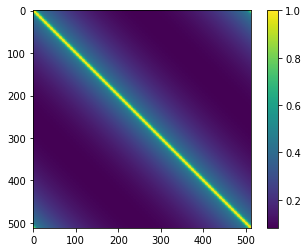

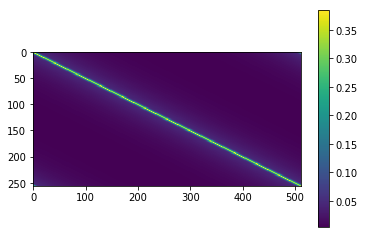

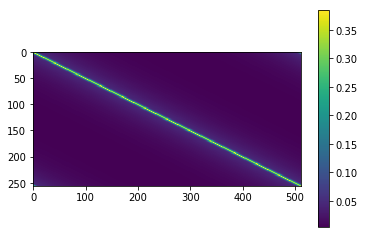

In [9]:
imshow(P_sqrt @ P_sqrt)
imshow(H @ P_sqrt)
imshow(U @ S @ VT)

In [10]:
ens_size = 20
X = assimilate.generate_ensemble(ens_size=ens_size,
                                 mu=np.zeros(dimension),
                                 eig_val=eig_val,
                                 eig_vec=eig_vec
                                 )
P_sample = np.cov(X)

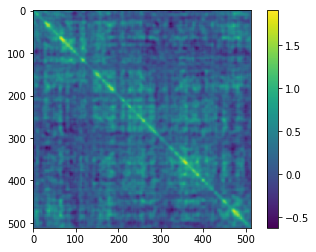

In [11]:
imshow(P_sample)

In [12]:
X_til = VT @ P_inv_sqrt @ X
P_sample_til = np.cov(X_til)

rho_smooth = 100
X_smooth = ndimage.gaussian_filter1d(X, sigma=rho_smooth, mode='wrap', axis=0)
X_til_smooth = VT @ P_inv_sqrt @ X_smooth
P_sample_til_smooth = np.cov(X_til_smooth)

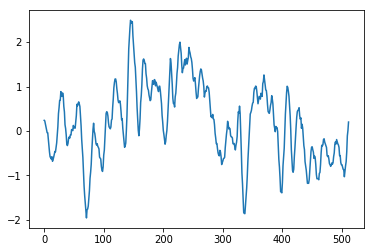

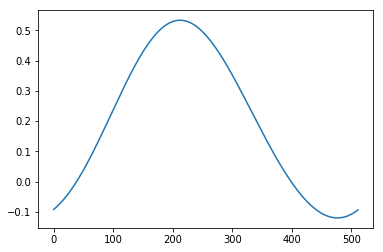

In [13]:
plt.figure()
plt.plot(X[:, 0])

plt.figure()
plt.plot(X_smooth[:, 0])

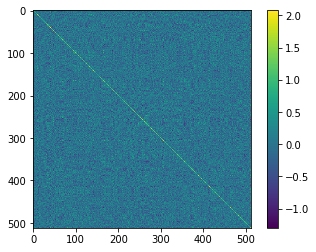

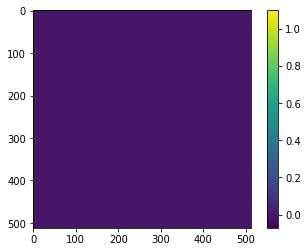

In [14]:
imshow(P_sample_til)
imshow(P_sample_til_smooth)

In [15]:
rho = np.arange(dimension)[None, :]
rho = np.abs(rho - rho.T)

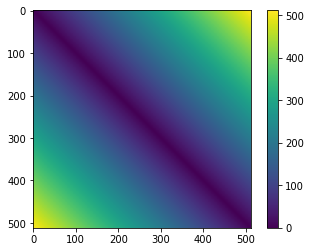

In [16]:
imshow(rho)

In [17]:
rho0 = 5
loc = covariance.correlation_sqd_exp(rho=rho, rho0=rho0)

In [18]:
P_sample_til_loc_smooth = loc * P_sample_til_smooth
# P_sample_til_loc_smooth = np.diag(np.diag(P_sample_til_loc_smooth))
P_sample_til_loc = loc * P_sample_til
# P_sample_til_loc = np.diag(np.diag(P_sample_til))

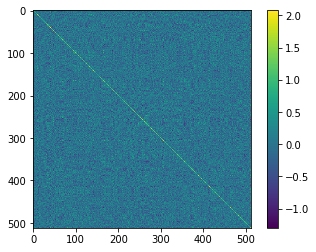

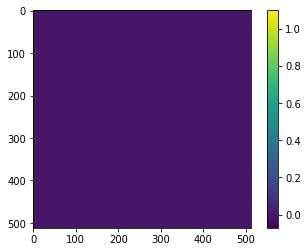

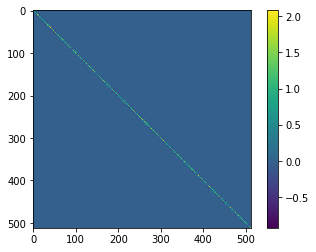

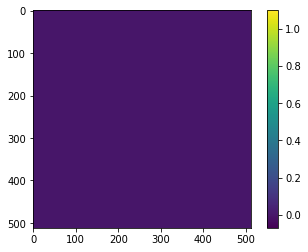

In [19]:
imshow(P_sample_til)
imshow(P_sample_til_smooth)
# imshow(loc)
imshow(P_sample_til_loc)
imshow(P_sample_til_loc_smooth)

In [20]:
# P_sample_til_loc_sqrt = np.real(covariance.matrix_sqrt(C=P_sample_til_loc))
# P_sample_til_loc_sqrt_smooth = np.real(covariance.matrix_sqrt(C=P_sample_til_loc_smooth))

In [21]:
# X_til_loc = assimilate.generate_ensemble(ens_size=ens_size*1000,
#                                          mu=np.zeros(dimension),
#                                          P_sqrt=P_sample_til_loc_sqrt)

In [22]:
# X_loc = P_sqrt @ VT.T @ X_til_loc

In [23]:
# imshow(P_sample_til_loc)

In [24]:
# P_sample_loc = np.cov(X_loc)

In [25]:
P_sample_loc = P_sqrt @ VT.T @ P_sample_til_loc @ VT @ P_sqrt
P_sample_loc_smooth = P_sqrt @ VT.T @ P_sample_til_loc_smooth @ VT @ P_sqrt

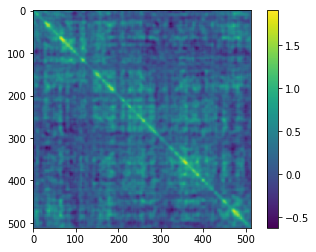

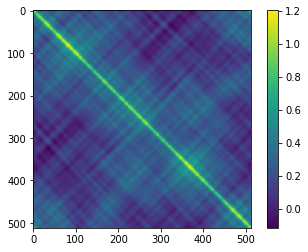

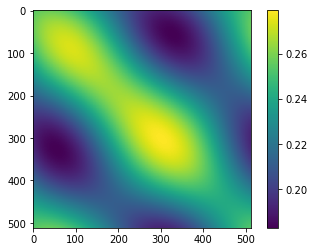

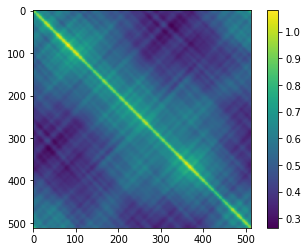

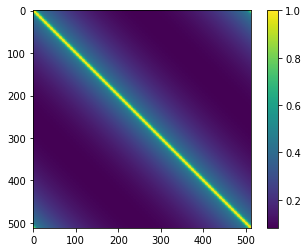

In [26]:
imshow(P_sample)
imshow(P_sample_loc)
imshow(P_sample_loc_smooth)
imshow(0.5*(P_sample_loc + 3.5*P_sample_loc_smooth))
imshow(P)

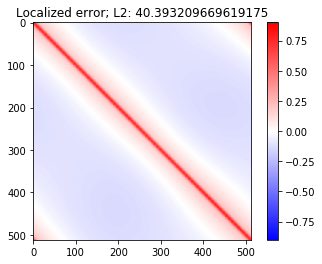

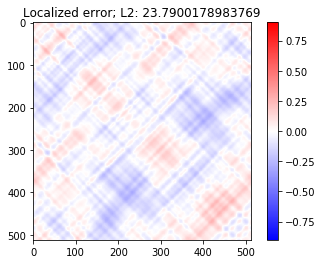

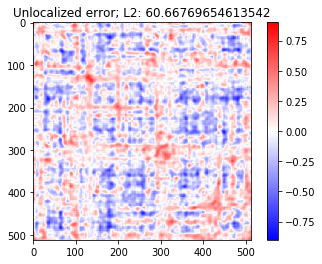

In [27]:
err_loc_smooth = P - P_sample_loc_smooth
L2_loc_smooth = np.linalg.norm(err_loc_smooth, ord=2)
err_loc = P - P_sample_loc
L2_loc = np.linalg.norm(err_loc, ord=2)
err = P - P_sample
L2 = np.linalg.norm(err, ord=2)
vmax = np.max(
    [np.abs(err_loc_smooth).max(),
     np.abs(err_loc).max(),
     np.abs(err).max()])
imshow(err_loc_smooth,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Localized error; L2: {L2_loc_smooth}')
imshow(err_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Localized error; L2: {L2_loc}')
imshow(err,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Unlocalized error; L2: {L2}')

In [ ]:
X_til = VT @ P_inv_sqrt @ X

In [ ]:
P_sample_loc = P_sqrt @ VT.T @ P_sample_til_loc @ VT @ P_sqrt

In [32]:
P_sample_til = VT @ P_inv_sqrt @ P_sample @ P_inv_sqrt @ VT.T
P_sample_loc = P_sqrt @ VT.T @ (loc * P_sample_til) @ VT @ P_sqrt

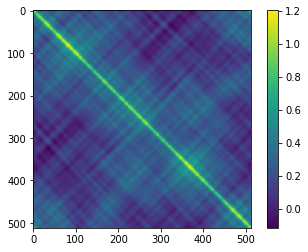

In [33]:
imshow(P_sample_loc)